Specify the fixVersions that you'd like to estimate.

In [46]:
fixVersions = ['1.12', '1.13', '1.14']

Loading data using JIRA API (https://jira.readthedocs.io/en/master/)

Password is provided using ~/.rcnet file

In [47]:
import pandas as pd
from jira import JIRA


#store credentials in ~/.rcnet file
jira = JIRA('https://kainos-evolve.atlassian.net')
jql = 'project=VXT and fixversion in (' + ", ".join(fixVersions) +')'
jql

'project=VXT and fixversion in (1.12, 1.13, 1.14)'

Above JQL will be used to download the data from Jira

In [48]:
issuesInVersions = jira.search_issues(jql)

issues = pd.DataFrame()
issues['version'] = ''
issues['key'] = ''
issues['type'] = ''
issues['status'] = ''
issues['SP'] = 0
issues['summary'] = ''

#add issues to dataframe
for issue in issuesInVersions:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in fixVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'team' : str(issue.fields.customfield_14200)
                }, ignore_index=True)
            
issues.sort_values("version", inplace=True)
issues = issues.loc[~(issues['status'].isin(['Completed', 'Rejected']))]
issues = issues.loc[(issues['team'].isin(['Gdansk Team 1']))]
issues

,version,key,type,status,SP,summary,team
43,1.12,VXT-3103,Story,In Development,2.0,Initial End-to-end test for the whole concept ...,Gdansk Team 1
44,1.12,VXT-3100,Story,Awaiting Review,5.0,Add Identity Provider Configuration,Gdansk Team 1
45,1.12,VXT-3082,Story,Ready to Test,8.0,Add service task for sending data to kafka (wi...,Gdansk Team 1
46,1.12,VXT-3080,Epic,In Progress,NaN,Outbound Integration - export Process Data to ...,Gdansk Team 1
10,1.12,VXT-3988,Bug,Awaiting Review,NaN,AD SSO login of a user without assigned roles ...,Gdansk Team 1
13,1.13,VXT-3976,Story,In Development,3.0,User access handling for users who open form t...,Gdansk Team 1
1,1.13,VXT-4026,Bug,Backlog,NaN,Visibility condition trigger for multi-line te...,Gdansk Team 1
2,1.13,VXT-4025,Story,In Code review,2.0,Rebrand IC configured default tenant logos/ima...,Gdansk Team 1
3,1.13,VXT-4021,Bug,Awaiting Review,NaN,"Form renderer tabs will display ""Required *"" w...",Gdansk Team 1
26,1.13,VXT-3759,Story,Backlog,3.0,OpenID JIT User Creation: Velocity Group Mapping,Gdansk Team 1


###### All stories should have SP value

Please review items below and add SP to issues where necessary. Missing estimations my skew the results later.

In [49]:
issues.loc[(issues['type'] == 'Story') & (issues['SP'].isnull())]


,version,key,type,status,SP,summary,team
41,1.13,VXT-3133,Story,Backlog,NaN,Data Models: Read for Practitioner Resource,Gdansk Team 1
12,1.13,VXT-3986,Story,Backlog,NaN,Keycloak HA,Gdansk Team 1
0,1.13,VXT-4028,Story,Tech Refinement,NaN,Disable GroovyScript execution in Activiti,Gdansk Team 1


In [50]:
#replace NaN values by 0 for grouping
issues = issues.fillna(0)
issues = issues.groupby(['version'], as_index=False)['SP'].sum()

issues

,version,SP
0,1.12,15.0
1,1.13,20.0
2,1.14,0.0


Manually calculate and set minimum, average and maximum velocity for the team 

In [51]:
minVelocity = 10
avgVelocity = 15
maxVelocity = 20

Calculate days using velocity above

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
versions = pd.DataFrame()
#add some data to play with first
#versions['version'] = ['1.12', '1.13', '1.14']
#versions['SP'] = [33, 40, 38]

#or get data directly from Jira
versions = issues

import math
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay

#calculate days for each version using velocity
versions['minVeloDays'] = np.ceil(versions.SP * 10 / minVelocity).astype(int)
versions['avgVeloDays'] = np.ceil(versions.SP * 10 / avgVelocity).astype(int)
versions['maxVeloDays'] = np.ceil(versions.SP * 10 / maxVelocity).astype(int)

#round up days
minVeloDays = math.ceil(sum(versions.minVeloDays))
avgVeloDays = math.ceil(sum(versions.avgVeloDays))
maxVeloDays = math.ceil(sum(versions.maxVeloDays))


#calculate rolling sum of days
versions['minSum'] = versions.minVeloDays.expanding(1).sum().astype(int)
versions['avgSum'] = versions.avgVeloDays.expanding(1).sum().astype(int)
versions['maxSum'] = versions.maxVeloDays.expanding(1).sum().astype(int)

#replace NaN with 0
versions = versions.fillna(0)


#add business days to today to calculate finish date
versions['finishDateMinVelo'] = 0
versions['finishDateAvgVelo'] = 0
versions['finishDateMaxVelo'] = 0
versions.finishDateMinVelo = versions.minSum.apply(lambda x: pd.to_datetime('today') + BDay(x))
versions.finishDateAvgVelo = versions.avgSum.apply(lambda x: pd.to_datetime('today') + BDay(x))
versions.finishDateMaxVelo = versions.maxSum.apply(lambda x: pd.to_datetime('today') + BDay(x))


versions['minVeloDaysToFinish'] = 0
versions['avgVeloDaysToFinish'] = 0
versions['maxVeloDaysToFinish'] = 0
versions.minVeloDaysToFinish = minVeloDays - versions.minSum
versions.avgVeloDaysToFinish = avgVeloDays - versions.avgSum
versions.maxVeloDaysToFinish = maxVeloDays - versions.maxSum

#add first row with today to create burndown chart
versions = versions.append(
        {'version': 'today', 
         'finishDateMinVelo': pd.to_datetime('today'),
         'finishDateMaxVelo': pd.to_datetime('today'),
         'finishDateAvgVelo': pd.to_datetime('today'),
         'minVeloDaysToFinish': minVeloDays,
         'avgVeloDaysToFinish': avgVeloDays,
         'maxVeloDaysToFinish': maxVeloDays
        }, ignore_index=True)

versions.sort_values("finishDateMinVelo", inplace=True)
            

versions

,version,SP,minVeloDays,avgVeloDays,maxVeloDays,minSum,avgSum,maxSum,finishDateMinVelo,finishDateAvgVelo,finishDateMaxVelo,minVeloDaysToFinish,avgVeloDaysToFinish,maxVeloDaysToFinish
3,today,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-14,2018-02-14,2018-02-14,35,24,18
0,1.12,15.0,15.0,10.0,8.0,15.0,10.0,8.0,2018-03-07,2018-02-28,2018-02-26,20,14,10
1,1.13,20.0,20.0,14.0,10.0,35.0,24.0,18.0,2018-04-04,2018-03-20,2018-03-12,0,0,0
2,1.14,0.0,0.0,0.0,0.0,35.0,24.0,18.0,2018-04-04,2018-03-20,2018-03-12,0,0,0


Plot data

Populating the interactive namespace from numpy and matplotlib


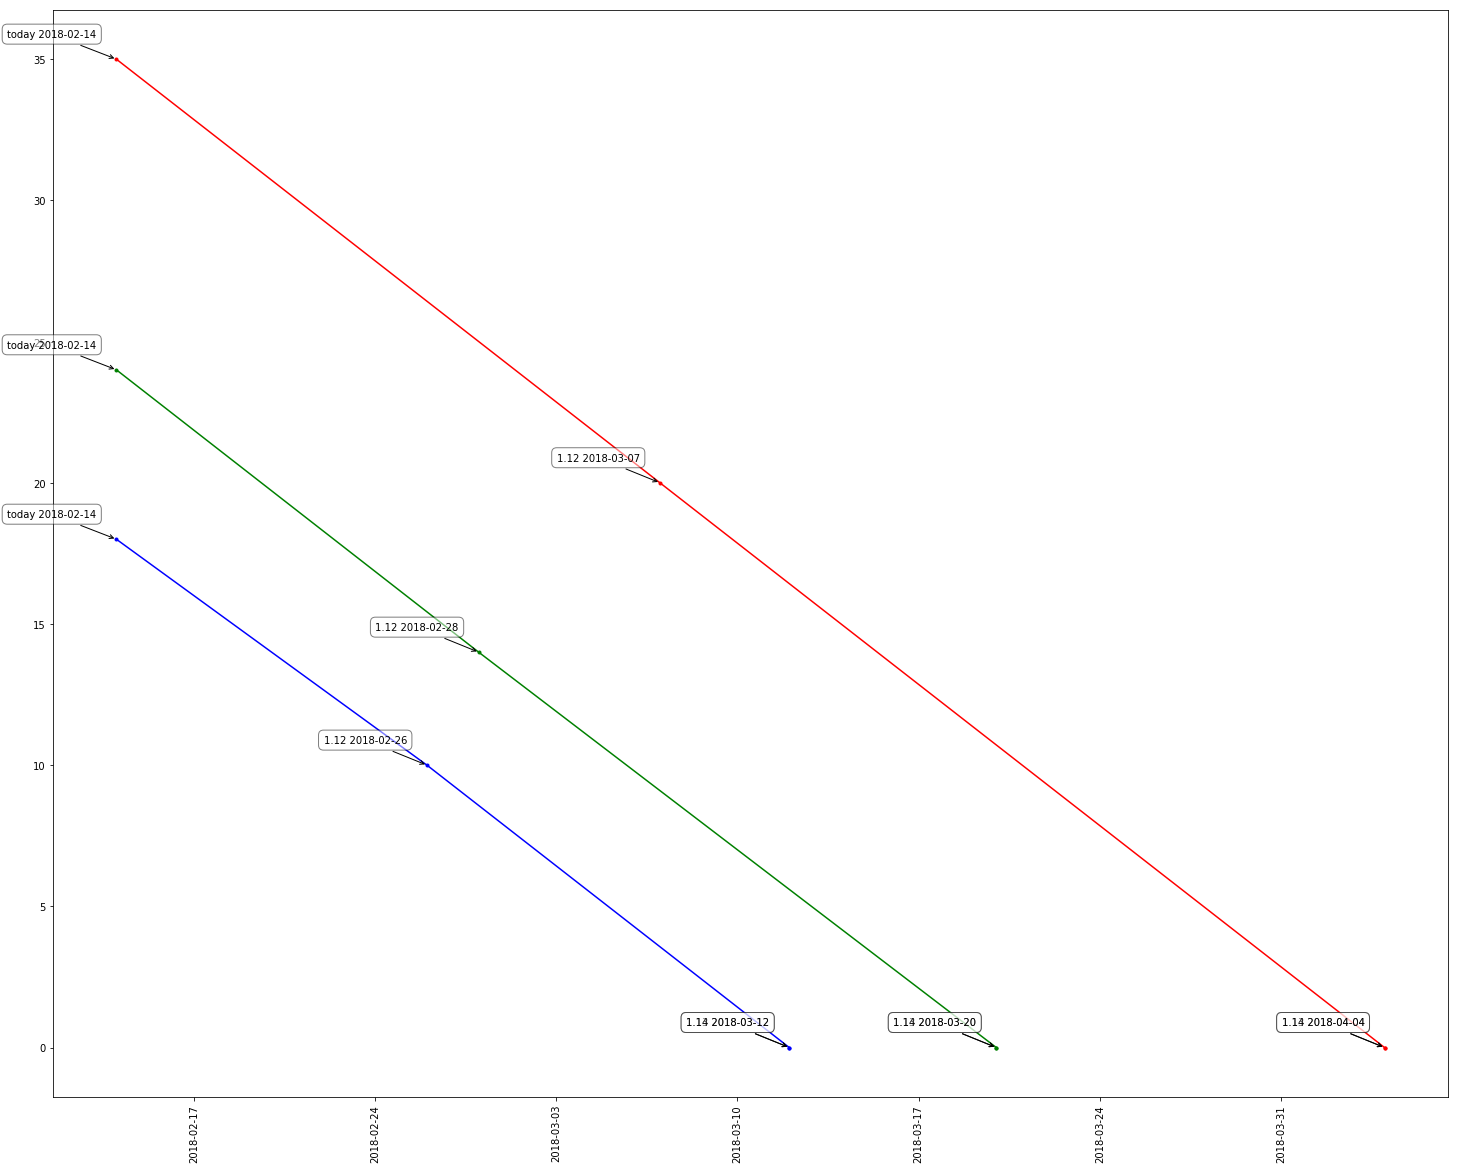

In [54]:
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 20)

_ = plt.plot(versions['finishDateMinVelo'], versions['minVeloDaysToFinish'], "-r.")
_ = plt.plot(versions['finishDateAvgVelo'], versions['avgVeloDaysToFinish'], "-g.")
_ = plt.plot(versions['finishDateMaxVelo'], versions['maxVeloDaysToFinish'], "-b.")

_ = plt.xticks(rotation='vertical')

for label, x, y in zip(versions['version'], versions['finishDateMinVelo'], versions['minVeloDaysToFinish']):
    _ = plt.annotate(
        label + " " + x.strftime('%Y-%m-%d'),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    
for label, x, y in zip(versions['version'], versions['finishDateAvgVelo'], versions['avgVeloDaysToFinish']):
    _ = plt.annotate(
        label + " " + x.strftime('%Y-%m-%d'),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


for label, x, y in zip(versions['version'], versions['finishDateMaxVelo'], versions['maxVeloDaysToFinish']):
    _ = plt.annotate(
        label + " " + x.strftime('%Y-%m-%d'),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
